# Regression CNN + MLP

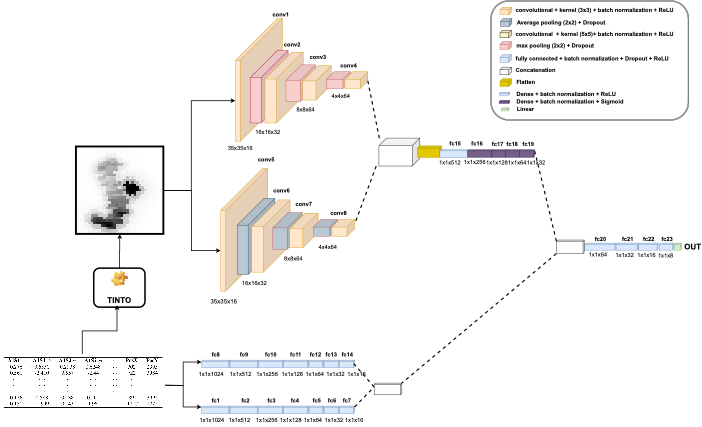

## Imports


In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image


from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, concatenate, AveragePooling2D, Concatenate
from keras.utils import plot_model
#from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.barGraph import BarGraph
from TINTOlib.combination import Combination
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.supertml import SuperTML
from TINTOlib.tinto import TINTO
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

# SET RANDOM SEED FOR REPRODUCIBILITY
SEED = 64
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-04-08 12:59:21.981050: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 12:59:21.994777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744109962.007922     791 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744109962.012148     791 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744109962.023409     791 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Processing

### Read the dataset

In [3]:
dataset_name = 'cancer'

#Read CSV
df = pd.read_csv(f"../resources/Datasets/{dataset_name}.csv")
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,45
0,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,1.0
1,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,1.0


In [4]:
df.shape

(568, 31)

- Extrameos cual será el tamaño cuadrático de la imagen

In [5]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

6


- Codificamos las variables en una imagen

In [6]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the last column with LabelEncoder
df.iloc[:, -1] = label_encoder.fit_transform(df.iloc[:, -1])

# Display the updated last column
print(df.iloc[:, -1])

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
563    1.0
564    1.0
565    1.0
566    1.0
567    0.0
Name: 45, Length: 568, dtype: float64


### Create images with TINTOLib

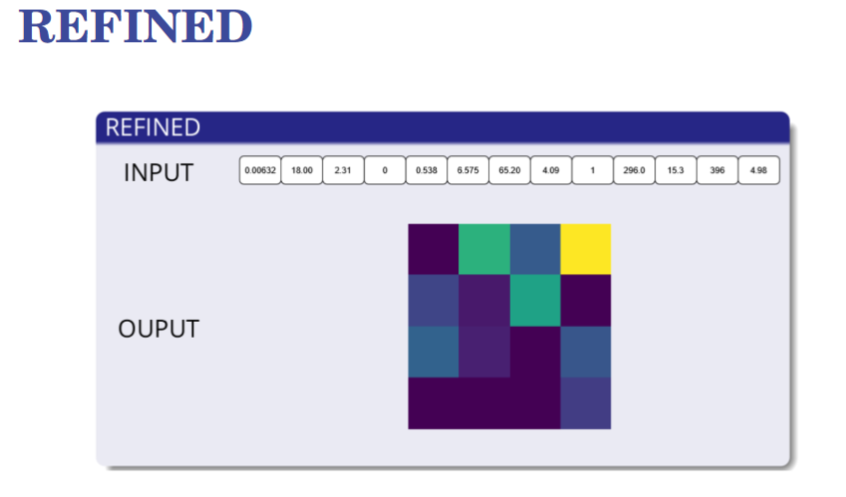

In [8]:
#Select the model and the parameters
problem_type = "supervised"
#problem_type = "regression"

# Transformation methods
image_model = REFINED(problem=problem_type, normalize=True, random_seed=SEED, zoom=4, n_processors=8)
name = f"REFINED"


#Define the dataset path and the folder where the images will be saved
results_folder = f"Results/{dataset_name}_{name}"
images_folder = f"Synthetic_images/images_{dataset_name}_{name}"

## Generate images

In [9]:
import cv2
from sklearn.preprocessing import MinMaxScaler

X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [11]:
def process_dataset(X, folder_name, generate_function, problem_type):
    """
    Handles dataset processing, including image generation, path updates, 
    and combining the dataset with image paths.

    Parameters:
    ----------
    X : DataFrame
        The dataset to process (training, validation, or test).
    
    folder_name : str
        The name of the folder where generated images will be stored 
        (e.g., 'train', 'val', 'test').
    
    generate_function : function
        The function used for training and generating images. It can be one of the following:
        - `fit`: Trains the model without generating images.
        - `fit_transform`: Trains the model and generates images for the dataset (used for training).
        - `transform`: Uses the pre-trained model to generate images for validation and testing.
    
    problem_type : str
        The type of problem being addressed (e.g., regression, supervised).
        This is used to locate the corresponding `.csv` file containing image paths.

    Returns:
    --------
    X_processed : DataFrame
        The dataset with updated image paths and raw tabular data, ready for further processing.
    
    y_processed : Series
        The labels corresponding to the dataset (target values).
    """
    # Generate the images if the folder does not exist
    folder_path = f"{images_folder}/{folder_name}"
    if not os.path.exists(folder_path):
        generate_function(X, folder_path)
    else:
        print(f"The images for {folder_name} are already generated")

    # Load image paths
    img_paths = os.path.join(folder_path, f"{problem_type}.csv")
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = folder_path + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X], axis=1)

    # Split data and labels
    X_processed = combined_dataset.drop(df.columns[-1], axis=1).drop("class", axis=1)
    y_processed = combined_dataset["class"]

    return X_processed, y_processed


In [12]:
### X_train
X_train, y_train = process_dataset(X_train, "train", image_model.fit_transform, problem_type)

In [13]:
### X_val
X_val, y_val = process_dataset(X_val, "val", image_model.transform, problem_type)

In [14]:
### X_test
X_test, y_test = process_dataset(X_test, "test", image_model.transform, problem_type)

## Pre-modeling

In [16]:
#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 channels (GRAY SCALE)
"""X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])"""

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale numerical data
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

attributes = X_train_num.shape[1]
height, width, channels = X_train_img[0].shape
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (24, 24, 3)
Attributres:  30
Image size (pixels): 24


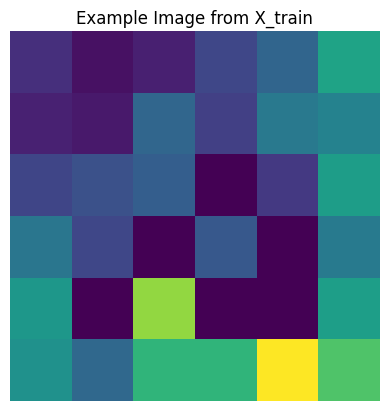

In [17]:
# Plot an example image (e.g., the first image in the array)
example_image = X_train_img[0]

# Convert the image from BGR (OpenCV default) to RGB for correct color display
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(example_image_rgb)
plt.title("Example Image from X_train")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

In [18]:
# Normalitation
X_train_img = X_train_img/255
X_val_img = X_val_img/255
X_test_img = X_test_img/255

## Modeling Hybrid Neural Networks: CNN + MLP

### FFNN for tabular data

In [19]:
dropout = 0.1

### **One-Branch MLP**

In [20]:
# Single branch FFNN
ff_inputs = Input(shape = (attributes,))

mlp_1 = Dense(64, activation='relu')(ff_inputs)
mlp_1 = Dense(32, activation='relu')(mlp_1)
mlp_1 = Dense(16, activation='relu')(mlp_1)
ff_model = Model(inputs = ff_inputs, outputs = mlp_1)

I0000 00:00:1744111052.899112     791 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1661 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


### **Two-Branch MLP**

In [22]:
# Two branch FFNN

ff_inputs_2 = Input(shape = (attributes,))

# * START BRANCH 1
mlp_1_2 = Dense(1024, activation='relu')(ff_inputs_2)
mlp_1_2 = BatchNormalization()(mlp_1_2)
mlp_1_2 = Dropout(dropout)(mlp_1_2)

mlp_1_2 = Dense(512, activation='relu')(ff_inputs_2)
mlp_1_2 = BatchNormalization()(mlp_1_2)
mlp_1_2 = Dropout(dropout)(mlp_1_2)

mlp_1_2 = Dense(256, activation='relu')(mlp_1_2)
mlp_1_2 = BatchNormalization()(mlp_1_2)
mlp_1_2 = Dropout(dropout)(mlp_1_2)

mlp_1_2 = Dense(128, activation='relu')(mlp_1_2)
mlp_1_2 = BatchNormalization()(mlp_1_2)
mlp_1_2 = Dropout(dropout)(mlp_1_2)

mlp_1_2 = Dense(64, activation='relu')(mlp_1_2)
mlp_1_2 = BatchNormalization()(mlp_1_2)
mlp_1_2 = Dropout(dropout)(mlp_1_2)

mlp_1_2 = Dense(32, activation='relu')(mlp_1_2)
mlp_1_2 = BatchNormalization()(mlp_1_2)
mlp_1_2 = Dropout(dropout)(mlp_1_2)

mlp_1_2 = Dense(16, activation='relu')(mlp_1_2)
mlp_1_2 = BatchNormalization()(mlp_1_2)
mlp_1_2 = Dropout(dropout)(mlp_1_2)

# * START BRANCH 2
mlp_2_2 = Dense(1024, activation='relu')(ff_inputs_2)
mlp_2_2 = BatchNormalization()(mlp_2_2)
mlp_2_2 = Dropout(dropout)(mlp_2_2)

mlp_2_2 = Dense(512, activation='relu')(ff_inputs_2)
mlp_2_2 = BatchNormalization()(mlp_2_2)
mlp_2_2 = Dropout(dropout)(mlp_2_2)

mlp_2_2 = Dense(256, activation='relu')(mlp_2_2)
mlp_2_2 = BatchNormalization()(mlp_2_2)
mlp_2_2 = Dropout(dropout)(mlp_2_2)

mlp_2_2 = Dense(128, activation='relu')(mlp_2_2)
mlp_2_2 = BatchNormalization()(mlp_2_2)
mlp_2_2 = Dropout(dropout)(mlp_2_2)

mlp_2_2 = Dense(64, activation='relu')(mlp_2_2)
mlp_2_2 = BatchNormalization()(mlp_2_2)
mlp_2_2 = Dropout(dropout)(mlp_2_2)

mlp_2_2 = Dense(32, activation='relu')(mlp_2_2)
mlp_2_2 = BatchNormalization()(mlp_2_2)
mlp_2_2 = Dropout(dropout)(mlp_2_2)

mlp_2_2 = Dense(16, activation='relu')(mlp_2_2)
mlp_2_2 = BatchNormalization()(mlp_2_2)
mlp_2_2 = Dropout(dropout)(mlp_2_2)

merged_tabular = Concatenate(axis=1)([mlp_1_2, mlp_2_2])

ff_model_2 = Model(inputs = ff_inputs_2, outputs = merged_tabular)

### **One-Branch CNN**

In [23]:
# Single branch CNN
#Input
input_shape = Input(shape=imgs_shape)

# CNN branch 1
tower_1 = Conv2D(16, (3,3), activation='relu',padding="same")(input_shape)
tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)

tower_1 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = Activation('relu')(tower_1)

tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = Activation('relu')(tower_1)

#Flatten
merged = Flatten()(tower_1)

#Dense layers
out = Dense(128, activation='relu')(merged)
out = Dense(64, activation='relu')(out)
out = Dense(32, activation='relu')(out)

cnn_model = Model(input_shape, out)

### **Two-Branch CNN**

In [24]:
#Input
input_shape_2 = Input(shape=imgs_shape)

# CNN branch 1
tower_1_2 = Conv2D(16, (3,3), activation='relu',padding="same")(input_shape_2)
tower_1_2 = BatchNormalization()(tower_1_2)
tower_1_2 = Activation('relu')(tower_1_2)
tower_1_2 = MaxPooling2D(2,2)(tower_1_2)
tower_1_2 = Dropout(dropout)(tower_1_2)

tower_1_2 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1_2)
tower_1_2 = BatchNormalization()(tower_1_2)
tower_1_2 = Activation('relu')(tower_1_2)
tower_1_2 = MaxPooling2D(2,2)(tower_1_2)
tower_1_2 = Dropout(dropout)(tower_1_2)

tower_1_2 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1_2)
tower_1_2 = BatchNormalization()(tower_1_2)
tower_1_2 = Activation('relu')(tower_1_2)
tower_1_2 = MaxPooling2D(2,2)(tower_1_2)
tower_1_2 = Dropout(dropout)(tower_1_2)

tower_1_2 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1_2)
tower_1_2 = BatchNormalization()(tower_1_2)
tower_1_2 = Activation('relu')(tower_1_2)
tower_1_2 = MaxPooling2D(2,2)(tower_1_2)
tower_1_2 = Dropout(dropout)(tower_1_2)

#CNN branch 2
tower_2_2 = Conv2D(16, (5,5), activation='relu',padding="same")(input_shape_2)
tower_2_2 = BatchNormalization()(tower_2_2)
tower_2_2 = Activation('relu')(tower_2_2)
tower_2_2 = AveragePooling2D(2,2)(tower_2_2)
tower_2_2 = Dropout(dropout)(tower_2_2)

tower_2_2 = Conv2D(32, (5,5), activation='relu',padding="same")(tower_2_2)
tower_2_2 = BatchNormalization()(tower_2_2)
tower_2_2 = Activation('relu')(tower_2_2)
tower_2_2 = AveragePooling2D(2,2)(tower_2_2)
tower_2_2 = Dropout(dropout)(tower_2_2)

tower_2_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2_2)
tower_2_2 = BatchNormalization()(tower_2_2)
tower_2_2 = Activation('relu')(tower_2_2)
tower_2_2 = AveragePooling2D(2,2)(tower_2_2)
tower_2_2 = Dropout(dropout)(tower_2_2)

tower_2_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2_2)
tower_2_2 = BatchNormalization()(tower_2_2)
tower_2_2 = Activation('relu')(tower_2_2)
tower_2_2 = AveragePooling2D(2,2)(tower_2_2)
tower_2_2 = Dropout(dropout)(tower_2_2)

#Concatenate CNN branches
merged = Concatenate(axis=1)([tower_1_2, tower_2_2])

#Flatten
merged = Flatten()(merged)

#Dense layers
out_2 = Dense(512, activation='relu')(merged)
out_2 = Dropout(dropout)(merged)
out_2 = Dense(256, activation='relu')(merged)
out_2 = Dropout(dropout)(merged)
out_2 = Dense(128, activation='sigmoid')(out_2)
out_2 = Dropout(dropout)(out_2)
out_2 = Dense(64, activation='sigmoid')(out_2)
out_2 = Dropout(dropout)(out_2)
out_2 = Dense(32, activation='sigmoid')(out_2)
out_2 = Dropout(dropout)(out_2)

cnn_model_2 = Model(input_shape_2, out_2)

## Concatenate CNN and MLP

### **One-Branch CNN + MLP**

In [26]:
combinedInput = concatenate([ff_model.output, cnn_model.output])
x = Dense(48, activation="relu")(combinedInput)
x = Dense(24, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[ff_model.input, cnn_model.input], outputs=x)

### **Two-Branch CNN + MLP**

In [27]:
combinedInput_2 = concatenate([ff_model_2.output, cnn_model_2.output])
x = Dense(48, activation="relu")(combinedInput_2)
x = Dense(24, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
model_2 = Model(inputs=[ff_model_2.input, cnn_model_2.input], outputs=x)

## Metrics

In [28]:
METRICS = [
    #tf.keras.metrics.TruePositives(name = 'tp'),
    #tf.keras.metrics.FalsePositives(name = 'fp'),
    #tf.keras.metrics.TrueNegatives(name = 'tn'),
    #tf.keras.metrics.FalseNegatives(name = 'fn'), 
    tf.keras.metrics.BinaryAccuracy(name ='accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc'),
]

- Print the hybrid model

In [29]:
os.makedirs(results_folder, exist_ok=True)

# Redirect the summary output to the specified file
with open(results_folder+"/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    
with open(results_folder+"/model_summary_2.txt", "w") as f:
    model_2.summary(print_fn=lambda x: f.write(x + '\n'))

# Disable automatic matplotlib display
plt.ioff()
# Save the model plot
plot_model(model, to_file=results_folder+'model_plot.png', show_shapes=True, expand_nested=True)
plot_model(model_2, to_file=results_folder+'model_plot_2.png', show_shapes=True, expand_nested=True)
# Re-enable automatic matplotlib display (optional)
plt.ion()

## Compile

In [30]:
opt = Adam(learning_rate=1e-3)
opt_2 = Adam(learning_rate=1e-3)

### **One-Branch CNN + MLP**

In [31]:
model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics = METRICS
)

In [32]:
# Configure EarlyStopping for binary classification
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [33]:
model_history=model.fit(
    x=[X_train_num, X_train_img], y=y_train,        ## Importante! pasamos una lista
    validation_data=([X_val_num, X_val_img], y_val),
    epochs=40,
    batch_size=16,
    callbacks = [early_stopper]
)

Epoch 1/40


I0000 00:00:1744112110.518743   14924 service.cc:152] XLA service 0x7f84800026c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744112110.518781   14924 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-04-08 13:35:10.573894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744112110.935241   14924 cuda_dnn.cc:529] Loaded cuDNN version 90800


18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5394 - auc: 0.5993 - loss: 0.6544 - precision: 0.3850 - recall: 0.3814 

I0000 00:00:1744112113.614779   14924 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.6039 - auc: 0.6645 - loss: 0.6149 - precision: 0.4780 - recall: 0.4250 - val_accuracy: 0.8772 - val_auc: 0.9471 - val_loss: 0.3428 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8396 - auc: 0.9157 - loss: 0.3620 - precision: 0.8622 - recall: 0.6736 - val_accuracy: 0.8947 - val_auc: 0.9669 - val_loss: 0.2651 - val_precision: 0.8261 - val_recall: 0.9048
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8995 - auc: 0.9666 - loss: 0.2322 - precision: 0.8763 - recall: 0.8423 - val_accuracy: 0.8596 - val_auc: 0.9735 - val_loss: 0.2471 - val_precision: 0.7407 - val_recall: 0.9524
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9405 - auc: 0.9832 - loss: 0.1639 - precision: 0.9215 - recall: 0.9125 - val_accuracy: 0.8596 - val_auc: 0.9722 - val_loss: 0.2953 - val_precision: 0.7407 - val_recall: 0.9524
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

In [34]:
print(model_history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


### **Two-Branch CNN + MLP**

In [35]:
model_2.compile(
    loss="binary_crossentropy",
    optimizer=opt_2,
    metrics = METRICS
)

In [36]:
# Configure EarlyStopping for binary classification
early_stopper_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [37]:
model_history_2=model_2.fit(
    x=[X_train_num, X_train_img], y=y_train,   ## Importante! pasamos una lista
    validation_data=([X_val_num, X_val_img], y_val),
    epochs=40,
    batch_size=16,
    callbacks = [early_stopper_2]
)

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 592ms/step - accuracy: 0.7918 - auc: 0.8922 - loss: 0.5145 - precision: 0.6892 - recall: 0.7886 - val_accuracy: 0.6316 - val_auc: 0.9993 - val_loss: 0.5923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9306 - auc: 0.9695 - loss: 0.2060 - precision: 0.9568 - recall: 0.8477 - val_accuracy: 0.6491 - val_auc: 0.9987 - val_loss: 0.4798 - val_precision: 1.0000 - val_recall: 0.0476
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9463 - auc: 0.9793 - loss: 0.1580 - precision: 0.9565 - recall: 0.8925 - val_accuracy: 0.8246 - val_auc: 0.9987 - val_loss: 0.3793 - val_precision: 1.0000 - val_recall: 0.5238
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9539 - auc: 0.9874 - loss: 0.1302 - precision: 0.9566 - recall: 0.9144 - val_accuracy: 0.8596 - val_auc: 0.9960 - val_loss: 0.3374 - val_precision: 1.0000 - val_recall: 0.6190
Epoch 5/40
29/29 ━━━━━━━━━━━━

In [38]:
print(model_history_2.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


## Results

### Train/Validation representation

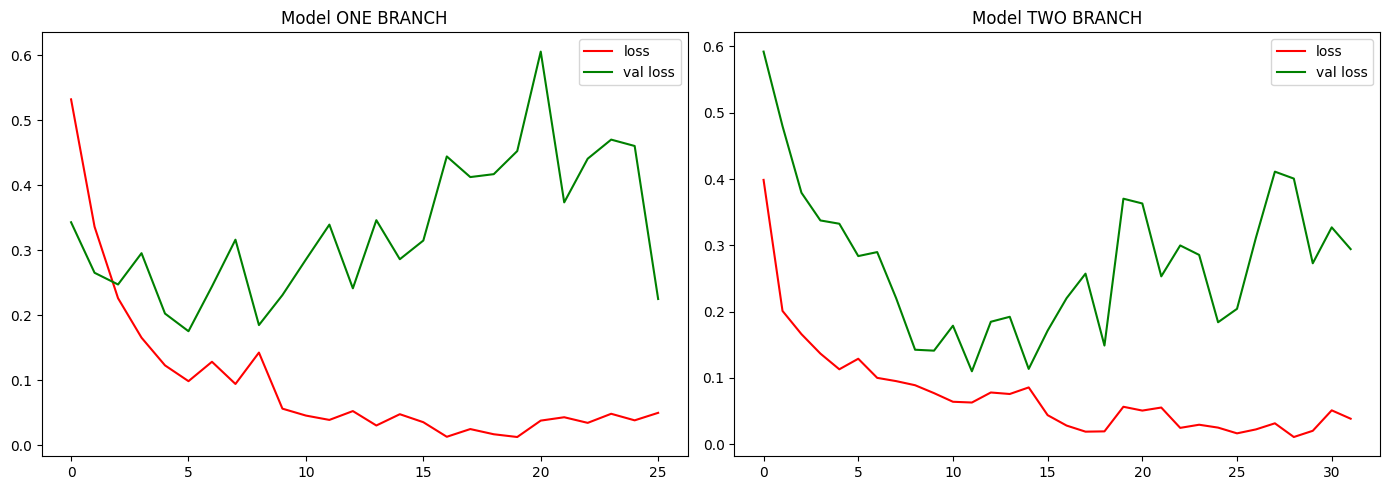

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Primer gráfico: Modelo ONE BRANCH
axes[0].plot(model_history.history['loss'], color='red', label='loss')
axes[0].plot(model_history.history['val_loss'], color='green', label='val loss')
axes[0].legend(loc='upper right')
axes[0].set_title('Model ONE BRANCH')

# Segundo gráfico: Modelo TWO BRANCH
axes[1].plot(model_history_2.history['loss'], color='red', label='loss')
axes[1].plot(model_history_2.history['val_loss'], color='green', label='val loss')
axes[1].legend(loc='upper right')
axes[1].set_title('Model TWO BRANCH')

plt.tight_layout()
plt.show()

### Train/Validation evaluation

In [47]:
score_test= model.evaluate([X_val_num, X_val_img], y_val)
score_test_2= model_2.evaluate([X_val_num, X_val_img], y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8986 - auc: 0.9798 - loss: 0.1750 - precision: 0.8307 - recall: 0.8631
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9545 - auc: 0.9982 - loss: 0.0969 - precision: 1.0000 - recall: 0.8631


In [48]:
prediction = model.predict([X_test_num, X_test_img])
real_values = y_test
predicted_classes = (prediction > 0.5).astype("int").reshape(-1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [52]:
prediction_2 = model_2.predict([X_test_num, X_test_img])
real_values_2 = y_test
predicted_classes_2 = (prediction_2 > 0.5).astype("int").reshape(-1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


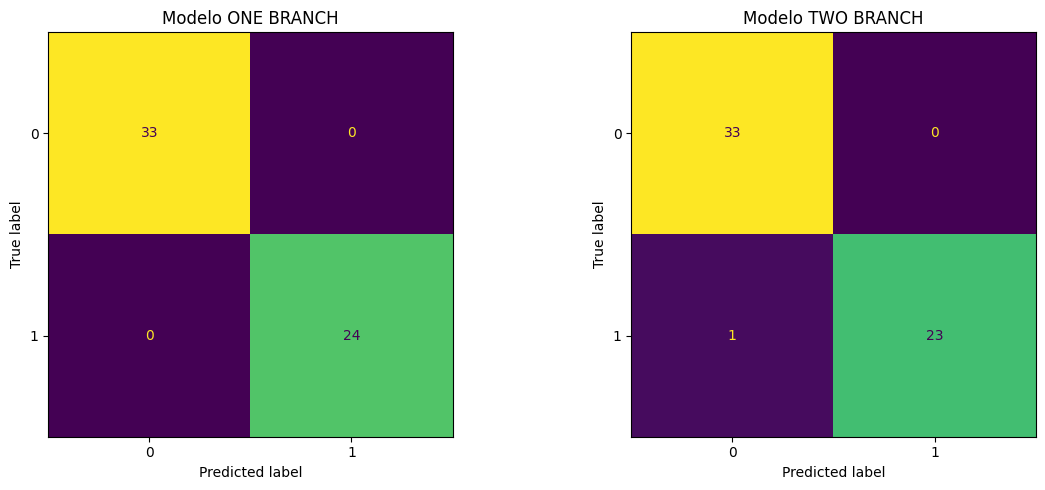

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular las matrices de confusión
cm_1 = confusion_matrix(real_values, predicted_classes)
cm_2 = confusion_matrix(real_values_2, predicted_classes_2)

# Crear subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mostrar la primera matriz
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1)
disp_1.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Modelo ONE BRANCH")

# Mostrar la segunda matriz
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp_2.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Modelo TWO BRANCH")

plt.tight_layout()
plt.show()
